# This Notebook estimates the model

## Settings

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from time import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from figure_manager import FigureManager
from plots import *

import DynamicTimeAllocationModel

path = 'output/'

fm = FigureManager(path, use_latex=False)

# c++ settings
do_compile = True
threads = 40

# from EconModel import cpptools
# cpptools.setup_nlopt(folder='cppfuncs/', do_print=True)

In [2]:
# setup model
settings = { 
       'T':30,
       'num_A': 15,
       'num_A_pd': 16,
       'num_K': 12,
       'num_power': 11,
       'num_love': 6,
       
       'max_A': 1_000,
       'max_A_pd': 1_000,
       'max_Ctot': 2_000,
       'max_K': 30,
       
       'init_couple_share': 0.77,
       
       'simT': 30,
       'simN': 10_000,

       'num_Ctot': 120,
       'num_marg_u':120,

       'phi': 1.0,
       'phi_mult': 1.0,
       
       'mu': 2.5,
       'mu_mult': 1.0,
       
       'gamma': 0.14,
       'gamma_mult': 1.0,
       
       'p_meet': 0.0,

       'threads':threads,
       'num_multistart': 2,
       
       'do_egm': True,
       'interp_method': 'linear',
       'interp_inverse': True,
       
       'precompute_intratemporal': True,
       'centered_gradient': True,
       }

model = DynamicTimeAllocationModel.HouseholdModelClass(par=settings) 
model.link_to_cpp(force_compile=do_compile)

## Empirical Moments to Match

In [3]:
# # all moments listed here will be used in estimation. Comment out those you do not want to use.
# datamoms = dict()

# # Wages (Adda et al, 2017, Table 1)
# datamoms['wage_level_w'] = 3.634
# datamoms['wage_level_m'] = 3.634

# datamoms[('wage_growth_w',5)] = 0.0510
# datamoms[('wage_growth_m',5)] = 0.0510

# datamoms[('wage_growth_w',10)] = 0.0208
# datamoms[('wage_growth_m',10)] = 0.0208

# datamoms[('wage_growth_w',15)] = 0.0133
# datamoms[('wage_growth_m',15)] = 0.0133

# # Time allocation (Blundell et al. 2018, Table 1, assuming 5*16*52=4160 annual hours)
# datamoms['time_work_w'] = 1750.0
# datamoms['time_work_m'] = 2074.0

# datamoms['time_leisure_w'] = 2410.0
# datamoms['time_leisure_m'] = 2086.0

# # consumption (Blundell et al. 2018, Table 1)
# datamoms['consumption'] = 42716.0


In [29]:
# all moments listed here will be used in estimation. Comment out those you do not want to use.
datamoms = dict()

# wages
datamoms['wage_level_w_25_34'] = 40.1
datamoms['wage_level_m_25_34'] = 49.3
datamoms['wage_level_w_35_44'] = 50.4
datamoms['wage_level_m_35_44'] = 67.8

# employment rates
datamoms['employment_rate_w_35_44'] = 64.0
datamoms['employment_rate_m_35_44'] = 88.0
datamoms['work_hours_w'] = 1674.0
datamoms['work_hours_m'] = 2062.0

# home production
datamoms['home_prod_w'] = 1535.0
datamoms['home_prod_m'] = 1035.0

# # consumption
datamoms['consumption'] = 42.716

# # marriage and divorce rates
# datamoms['marriage_rate_35_44'] = 69.0
# datamoms['divorce_rate_35_44'] = 12.0


# weights
weights = dict()
for mom in ('work_hours_w', 'work_hours_m', 'home_prod_w', 'home_prod_m'):
    weights[mom] = 0.01


## Parameters to estimate

In [ ]:
# parameters to estimate
estpars = {
    # Wages
    # 'mu': {'guess':3.5172,'lower':1.0,'upper':5.00}, 
    # 'mu_mult': {'guess':1.0533,'lower':0.5,'upper':2.0},
    # 'gamma': {'guess':0.0677,'lower':0.05,'upper':0.20},
    # 'gamma_mult': {'guess':1.1857,'lower':0.5,'upper':2.0},

    # Disutility from work
    'eta': {'guess':0.5211,'lower':1.1,'upper':4.0},
    'eta_mult': {'guess':1.0,'lower':0.5,'upper':3.0},
    'phi': {'guess':0.7,'lower':0.1,'upper':4.0},
    'phi_mult': {'guess':1.0,'lower':0.5,'upper':3.0},
    
    # Home production
    # 'alpha': {'guess':1.0,'lower':0.9,'upper':1.9},
    # 'zeta': {'guess':0.5,'lower':0.1,'upper':2.0},
    # 'omega': {'guess':0.5,'lower':0.1,'upper':2.0},
    # 'pi': {'guess':0.5,'lower':0.1,'upper':0.9},
    # 'lambda_': {'guess':0.5,'lower':0.1,'upper':100.0},
    
    # # Match quality
    # 'sigma_love': {'guess':0.15,'lower':0.01,'upper':0.5},
    # 'div_cost': {'guess':0.0,'lower':0.0,'upper':100.0},
}


# set parameters to these values if not estimated
use_fixed_init = True # overwrites initial guesses in estpars if True
fixed = {
    'mu': 3.5172, 
    'mu_mult': 1.0533,
    'gamma': 0.0677,
    'gamma_mult': 1.1857,
    
    'eta'            : 2.85,
    'eta_mult'       : 1.0,
    'phi'            : 1.97,
    'phi_mult'       : 1.0,

    'alpha'          : 1.18,
    'zeta'           : 0.40,
    'omega'          : 0.38,
    'pi'             : 0.5,
    
    'lambda_'        : 10.0,
    
    'sigma_love': 0.15,
    'div_cost': 0.0,
}

# equal
# fixed = {
#     'mu': 3.5172, 
#     'mu_mult': 1.0,
#     'gamma': 0.0677,
#     'gamma_mult': 1.0,
    
#     'eta'            : 2.85,
#     'eta_mult'       : 1.0,
#     'phi'            : 1.97,
#     'phi_mult'       : 1.0,

#     'alpha'          : 1.0,#too much specialization with these wage differences
#     'zeta'           : 0.40,
#     'omega'          : 0.38,
#     'pi'             : 0.5,
    
#     'lambda_'        : 10.0,
    
#     'sigma_love': 0.15,
#     'div_cost': 0.0,
# }

# Mazzocco et al:
# fixed = {
#     'mu': 3.5172, 
#     'mu_mult': 1.0533,
#     'gamma': 0.0677,
#     'gamma_mult': 1.1857,
    
#     'eta'            : 2.85,
#     'eta_mult'       : 1.0,
#     'phi'            : 1.97,
#     'phi_mult'       : 1.0,

#     'alpha'          : 1.18,
#     'zeta'           : 0.40,
#     'omega'          : 0.38,
#     'pi'             : 0.5,
    
#     'lambda_'        : 10.0,
    
#     'sigma_love': 0.15,
#     'div_cost': 0.0,
# }


## setup initial guess 

In [31]:
# set fixed parameters and potentially update initial values
for key in fixed.keys():
    if key not in estpars.keys():
        setattr(model.par,key,fixed[key])
    
    else:
        if use_fixed_init:
            estpars[key]['guess'] = fixed[key]
        

In [ ]:
# check bounds
bounds_ok = True
for key in estpars.keys():
    if estpars[key]['guess']<estpars[key]['lower']:
        print(key,' lower',estpars[key]['guess'])
        bounds_ok = False
    
    if estpars[key]['guess']>estpars[key]['upper']:
        print(key,' upper',estpars[key]['guess'])
        bounds_ok = False

if not bounds_ok:
    stop

In [33]:
# check initial guess
theta_init = np.array([estpars[key]['guess'] for key in estpars.keys()])
obj_init = model.obj_func(theta_init,estpars, datamoms,weights, do_print=True)

Parameters:
  eta            : 2.8500 (init: 2.8500)
  eta_mult       : 1.0000 (init: 1.0000)
  phi            : 1.9700 (init: 1.9700)
  phi_mult       : 1.0000 (init: 1.0000)
Moments:
  wage_level_w_25_34       : sim: 48.1169, data: 40.1000
  wage_level_m_25_34       : sim: 52.8609, data: 49.3000
  wage_level_w_35_44       : sim: 53.1750, data: 50.4000
  wage_level_m_35_44       : sim: 63.2128, data: 67.8000
  employment_rate_w_35_44  : sim: 29.3551, data: 64.0000
  employment_rate_m_35_44  : sim: 94.5705, data: 88.0000
  work_hours_w             : sim: 1239.8953, data: 1674.0000
  work_hours_m             : sim: 1980.6005, data: 2062.0000
  home_prod_w              : sim: 2689.4309, data: 1535.0000
  home_prod_m              : sim: 1987.1260, data: 1035.0000
  consumption              : sim: 34.3529, data: 42.7160
Objective function value: 1687.1731 (penalty: 0.0000, 24.6646)
-------------------------------------


check that solution makes sense

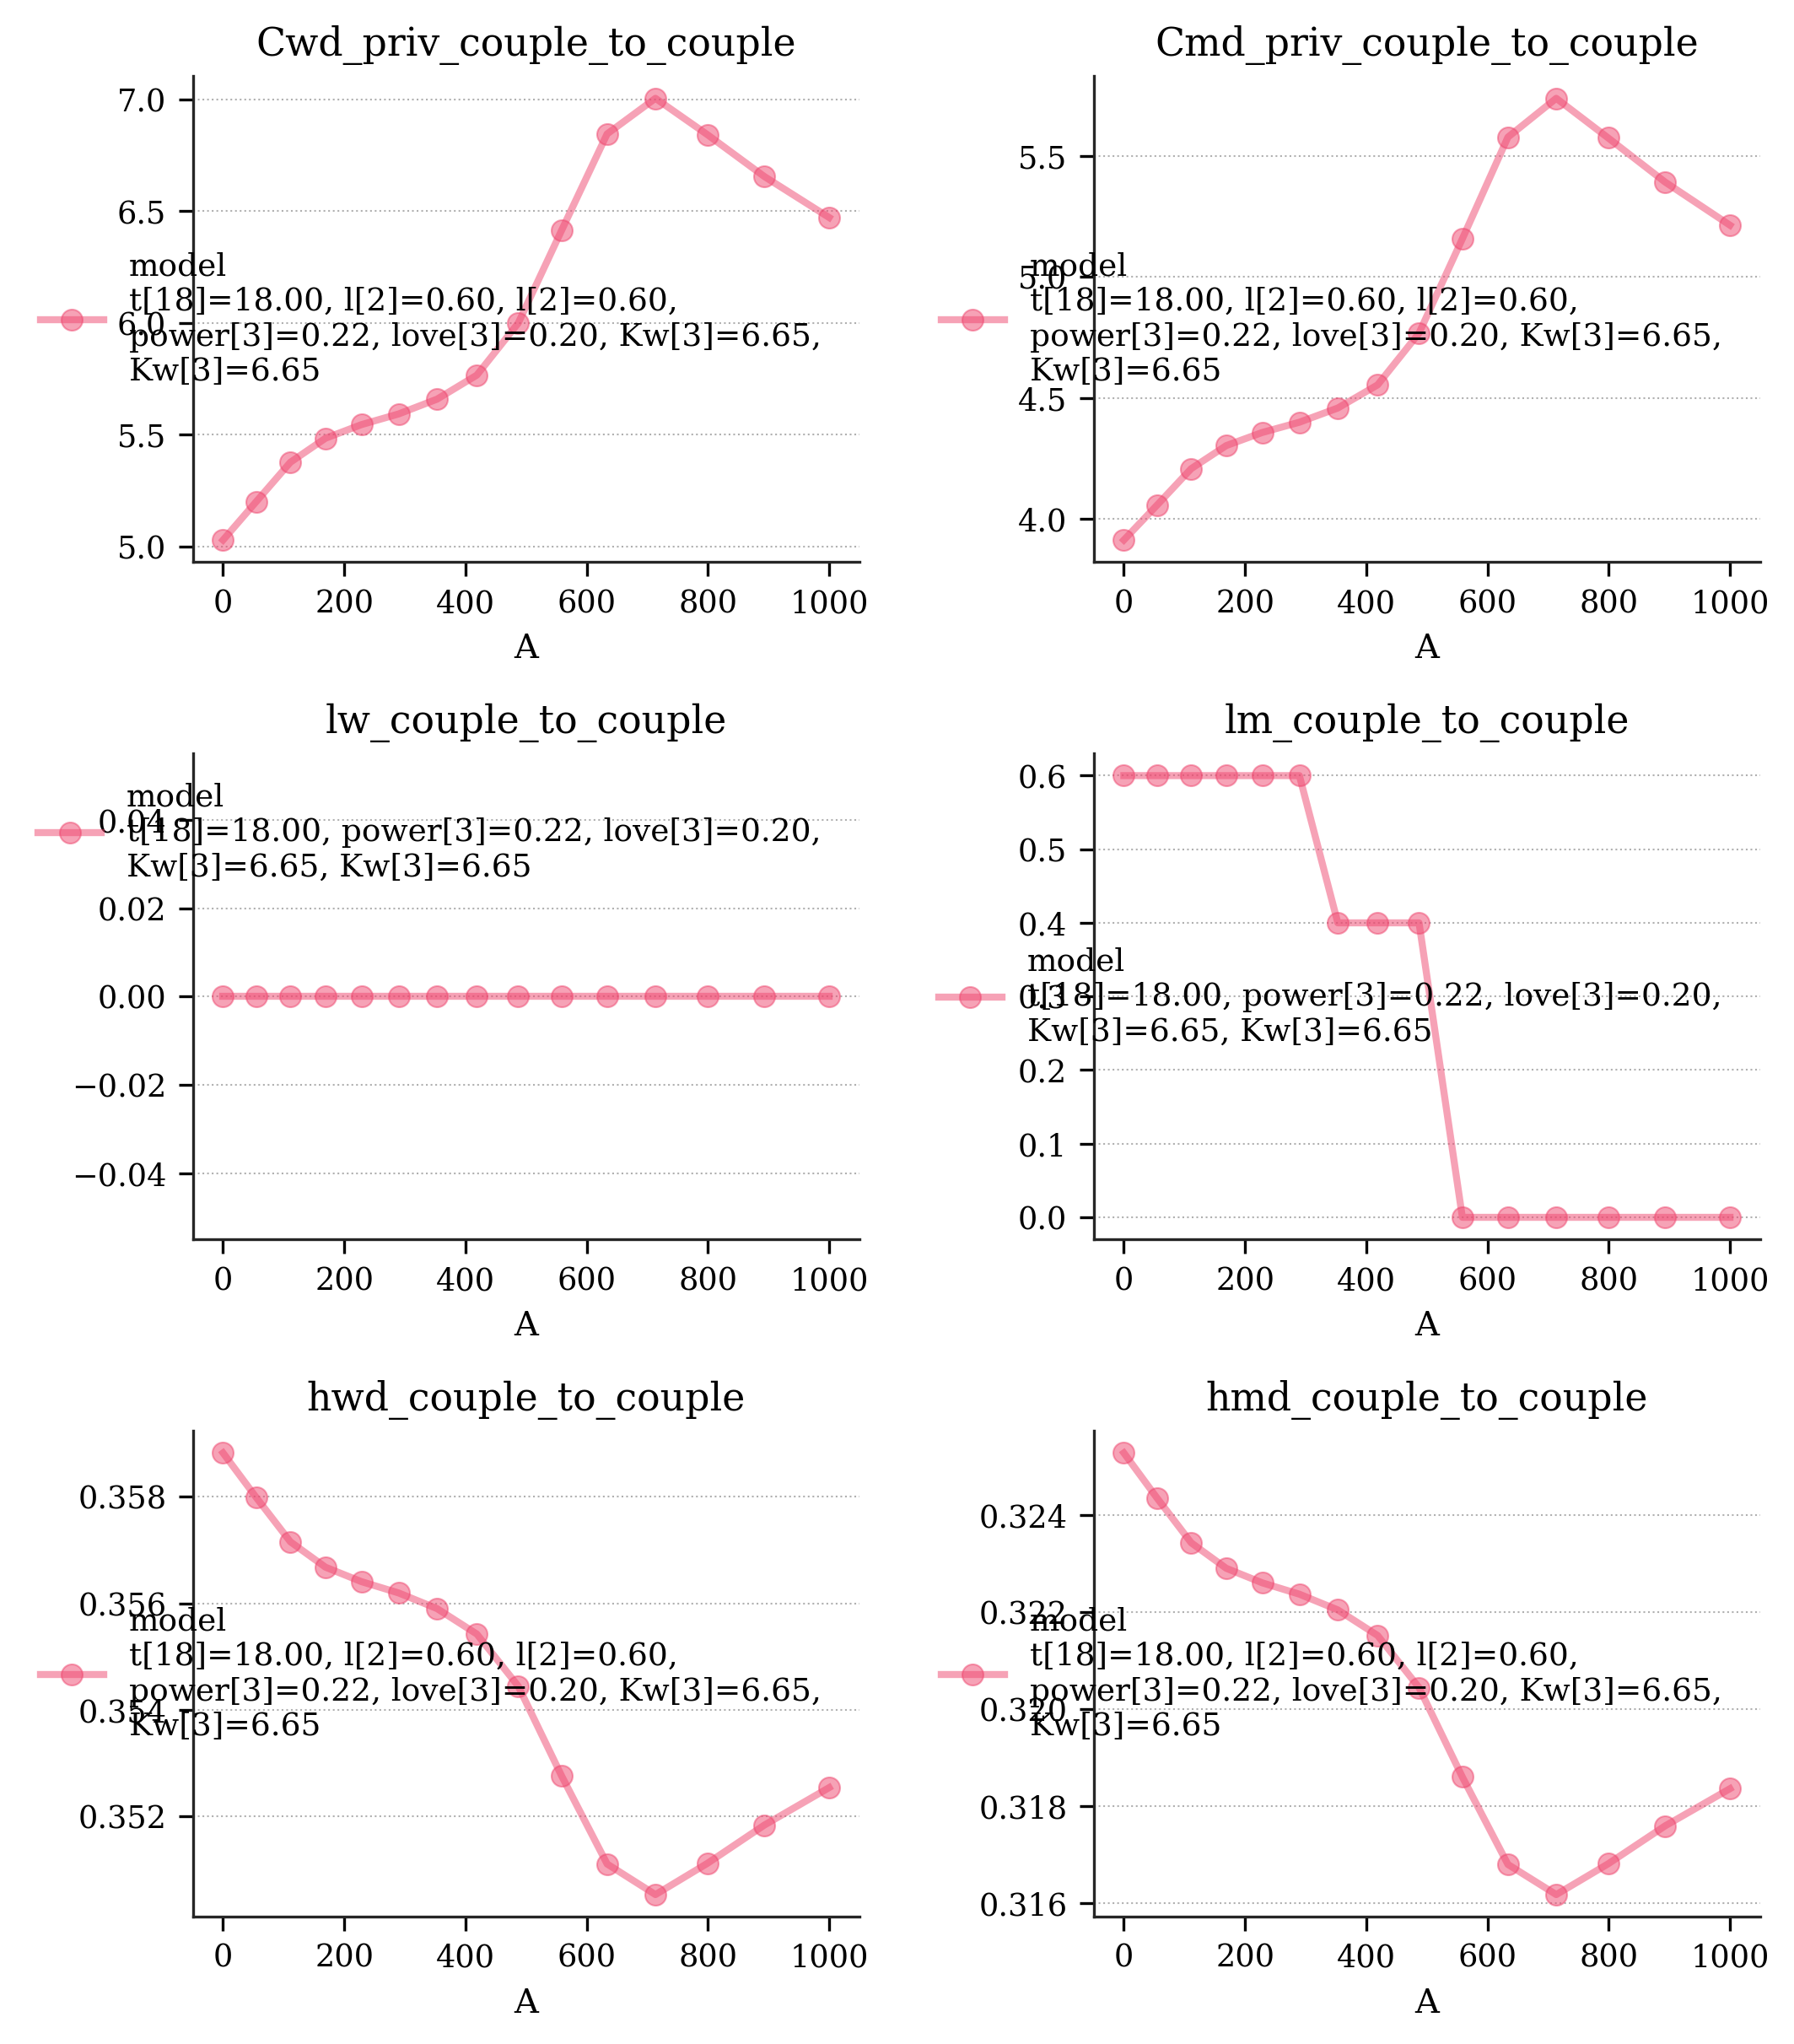

In [9]:
from plots import *

grid = 'grid_A'
idx = {'t': 18, 'il':2, 'iK': 3, 'iP': 3, 'iL': 3, 'iA': 10, 'iA_pd': 10}

mp = model_plotter(model, model_name='model', titles=['variable'], labels=['model', 'index'])
fig, ax = fm.create_figure(3,2,6)
mp.plot_gender_couple_choices(ax, grid=grid, index=idx, alpha=0.5)
fig.tight_layout()

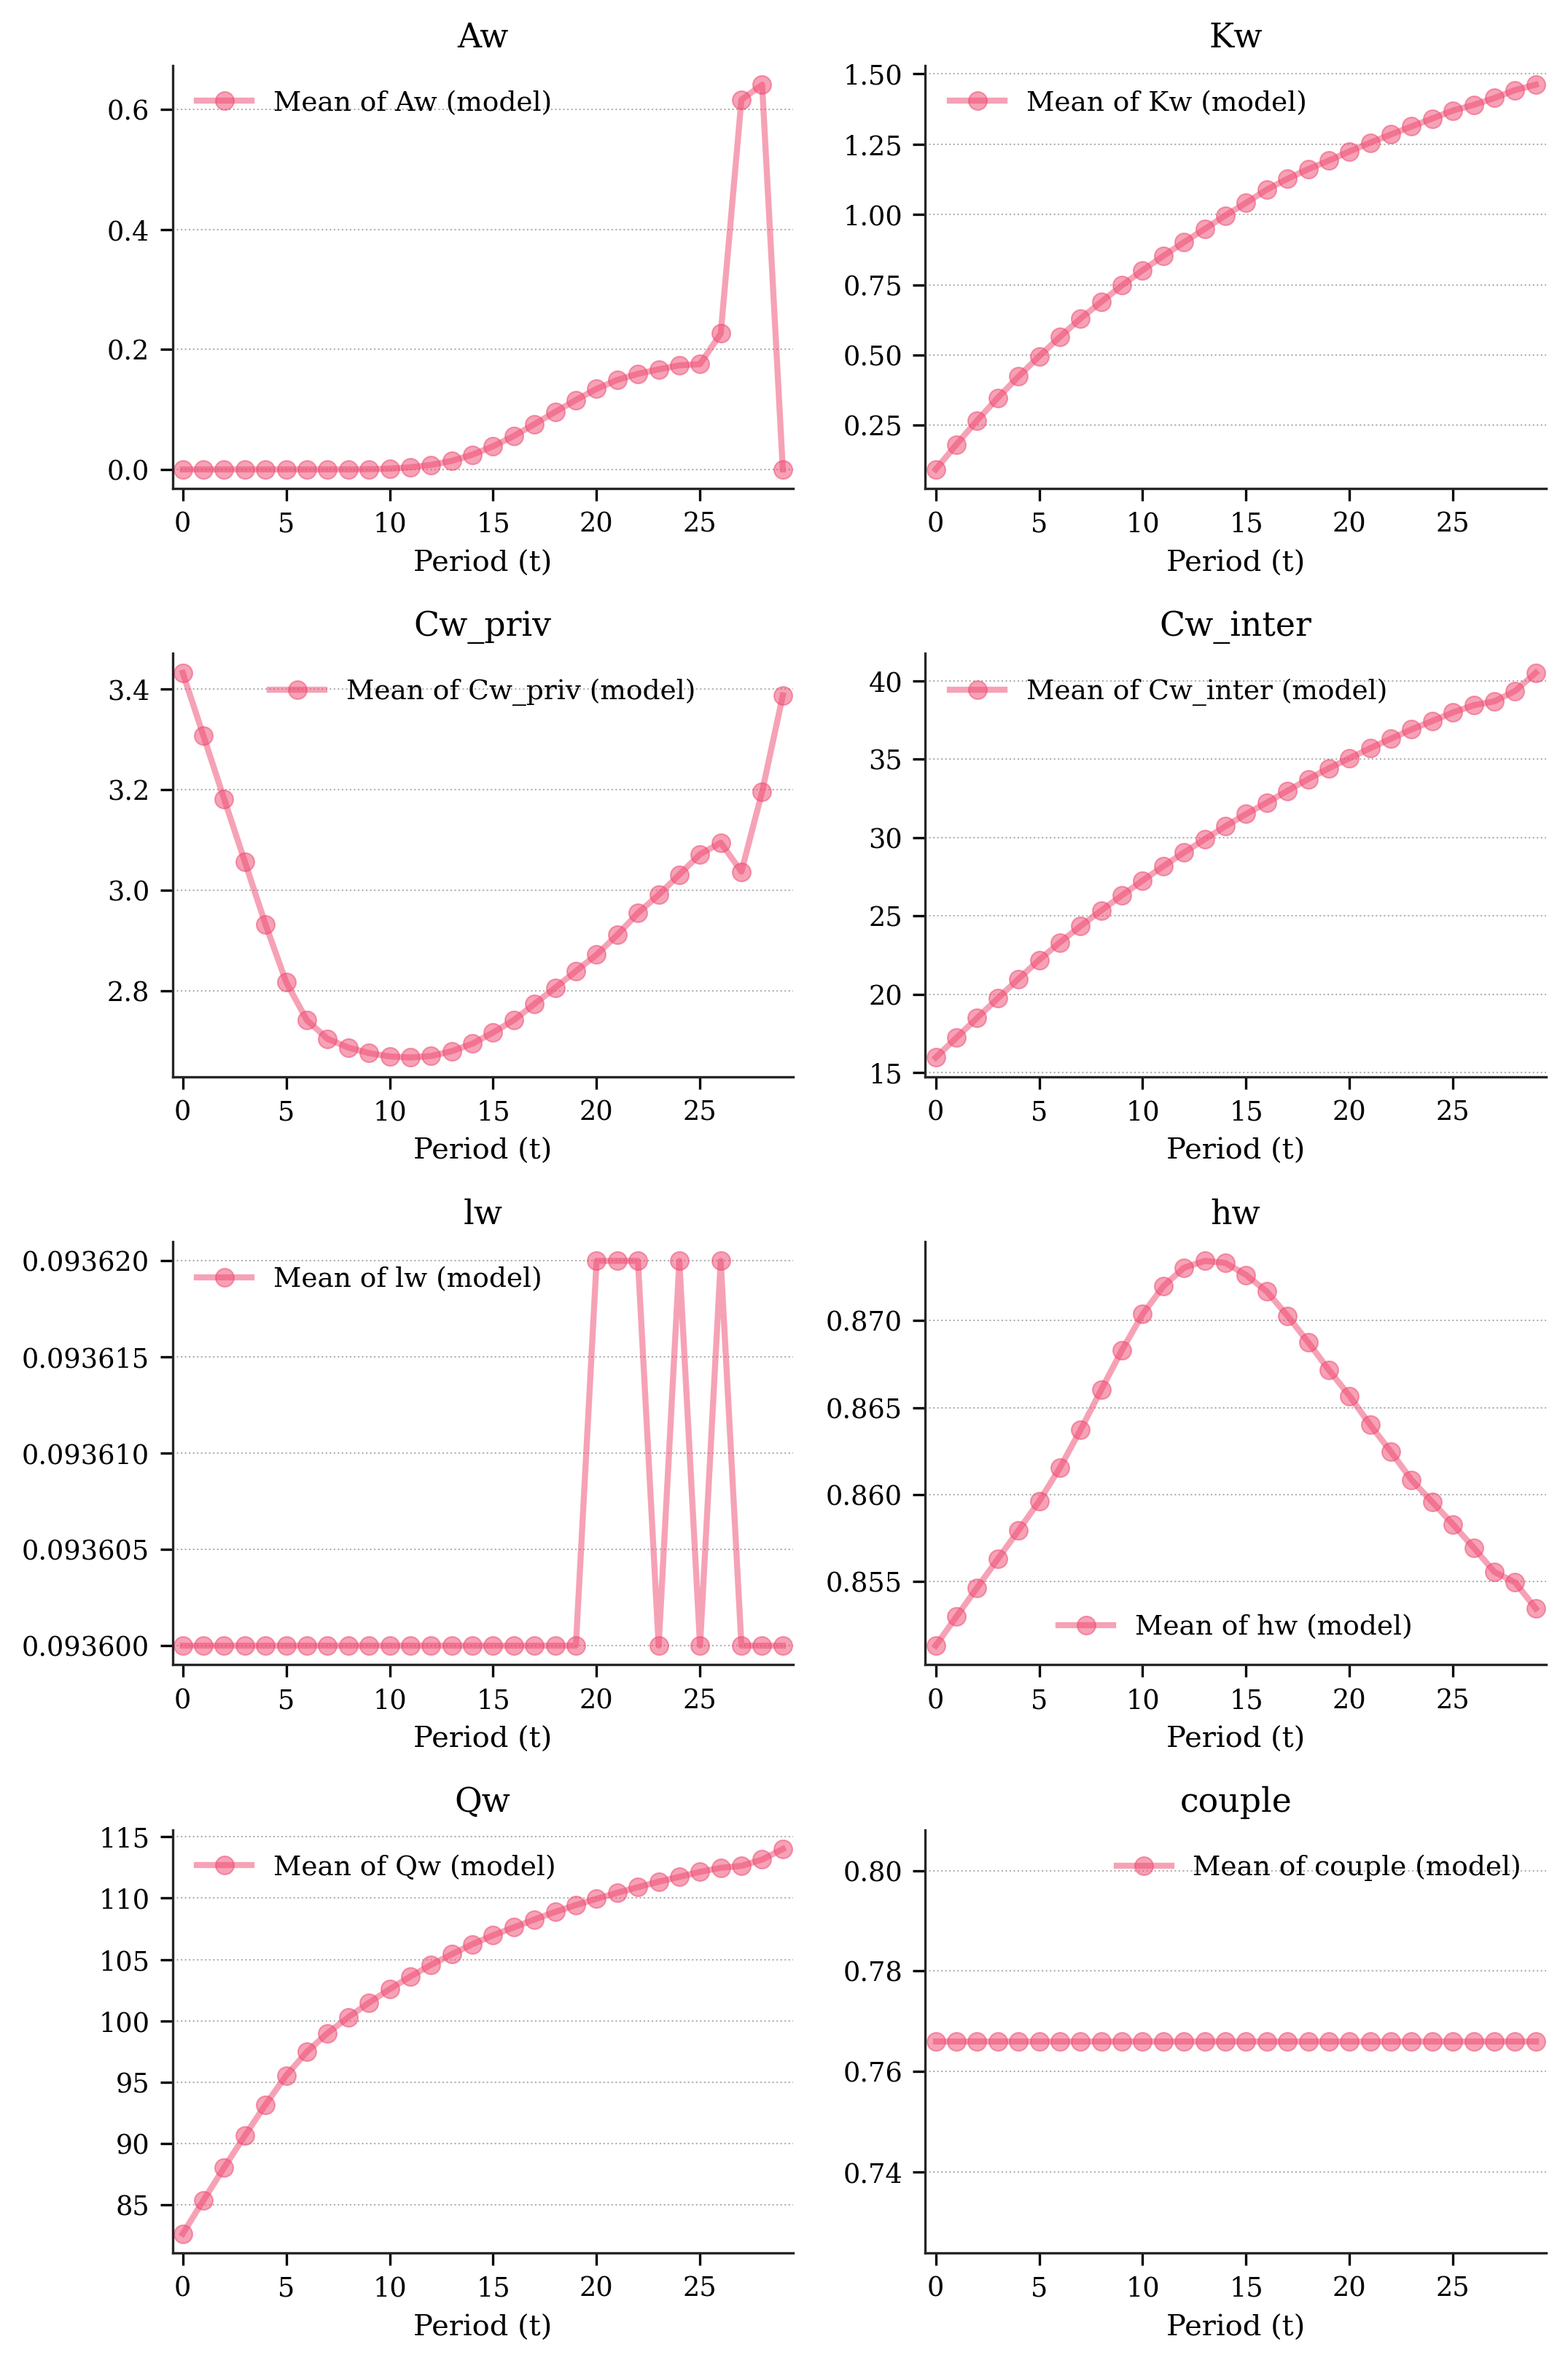

In [10]:
fig, ax = fm.create_figure(4,2,8)
mp.plot_sim_female(ax, alpha=0.5)
fig.tight_layout()

In [11]:
# stop

## Estimate model

In [37]:
DO_GLOBAL = True
num_points = 5
num_guess = 2

if DO_GLOBAL:
    theta_guesses = model.global_search(estpars, datamoms,weights,num_points,num_guess=num_guess,do_print=False)

    for i in range(num_guess):
        model.obj_func(theta_guesses[i],estpars, datamoms,weights, do_print=True)


e:\THJ\Projects\FastBargaining\Application\DynamicTimeAllocationModel.py:669: RuntimeWarning: Mean of empty slice
  moms['wage_level_w_25_34'] = np.nanmean(sim.wage_w[age_25_to_34_mask & couple_mask & full_time_w_mask])
e:\THJ\Projects\FastBargaining\Application\DynamicTimeAllocationModel.py:671: RuntimeWarning: Mean of empty slice
  moms['wage_level_w_35_44'] = np.nanmean(sim.wage_w[age_35_to_44_mask & couple_mask & full_time_w_mask])


Parameters:
  eta            : 2.1875 (init: 2.8500)
  eta_mult       : 1.0556 (init: 1.0000)
  phi            : 3.8440 (init: 1.9700)
  phi_mult       : 1.2143 (init: 1.0000)
Moments:
  wage_level_w_25_34       : sim: 47.9299, data: 40.1000
  wage_level_m_25_34       : sim: 53.6894, data: 49.3000
  wage_level_w_35_44       : sim: 53.7232, data: 50.4000
  wage_level_m_35_44       : sim: 64.2942, data: 67.8000
  employment_rate_w_35_44  : sim: 50.1854, data: 64.0000
  employment_rate_m_35_44  : sim: 95.3564, data: 88.0000
  work_hours_w             : sim: 1578.5976, data: 1674.0000
  work_hours_m             : sim: 1986.8845, data: 2062.0000
  home_prod_w              : sim: 2297.3331, data: 1535.0000
  home_prod_m              : sim: 1939.5644, data: 1035.0000
  consumption              : sim: 35.5843, data: 42.7160
Objective function value: 596.6680 (penalty: 0.0000, 55.5261)
-------------------------------------
Parameters:
  eta            : 3.2750 (init: 2.8500)
  eta_mult       : 

In [ ]:
stop

In [ ]:
# Estimate model using nelder-mead algorithm
do_print = True # Turn off... 
res = minimize(model.obj_func, theta_init, args=(estpars, datamoms,weights,do_print), method='Nelder-Mead',
               options={'xatol': 1e-4, 'fatol': 1e-4, 'disp': True, 'maxiter':5000})
